In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here, sin([x1...x2]) -> sin([x2...x3])

In [5]:
def gen_xy_sin_to_f(n_samples=500, n_t=1000, f=None, dt=0.01):
    # x_train = array (unique_samples, xs_over_t, sin(xs))
    # y_train = array (unique_samples, xs_over_t, sin(xs + dx))
    max_t = n_t * dt
    min_f = utils.min_f(max_t)
    max_f = utils.max_f(dt)
    print('allowed min max f', min_f, max_f)
    min_f = 5
    max_f = 15
    if f is None:
        fs = np.random.random(n_samples) * (max_f - min_f) + min_f
    else:
        fs = np.repeat(f, n_samples)
        
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []
    n_categories = 2
    for i, phase in enumerate(phases):
        # x: beginning of cycle
        f = fs[i]
        d_phase = n_t * dt * f
        data = sin_(n_t, f, phase)
        x_train.append(sin_(n_t, f, phase, n_categories))
        # y: continuation of cycle        
        y_train.append(sin_(n_t, f, phase + d_phase, n_categories))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, n_categories) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, n_categories)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01, n_categories=2):
    ts = np.arange(n) * dt    
    ts_ = ts.reshape(ts.shape[0],1)
    ts = np.stack([ts_ for _ in range(n_categories)], axis=1)
    return (np.sin(2*np.pi * f * ts + phase * 2 * np.pi) + 1) * 0.5

In [6]:
n = 2
f = None
# f = 3
dt = 0.01
x_train, y_train = gen_xy_sin_to_f(n, f=f, dt=dt)
y_train = x_train[:,:-1,:]
z_train = x_train[:,1:,:]

encoder_input_data = y_train # english sentences
decoder_input_data = y_train # french sentences (copy)
decoder_target_data = z_train # french sentences, next timestep

x_test, y_test = gen_xy_sin_to_f(10, f=f, dt=dt)
print(x_train.shape, y_train.shape, z_train.shape)

allowed min max f 0.1 50.0
allowed min max f 0.1 50.0
(2, 1000, 2) (2, 999, 2) (2, 999, 2)


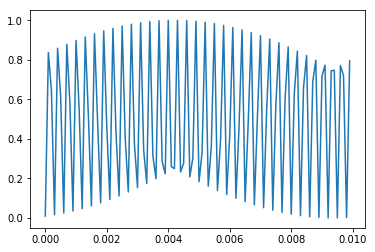

In [7]:
n4 = x_train.shape[1]
n4 = 100
plt.plot(np.arange(n4) / n4 * dt, x_train[0,:n4,0])

In [8]:
# plt.plot(np.arange(n4) / n4 * dt, y_train[0])

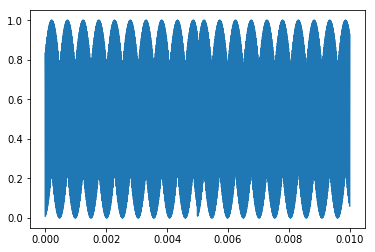

In [9]:
full = np.concatenate([x_train[0,:,0],y_train[0,:,0]])
n5 = full.shape[0]
plt.plot(np.arange(n5) / n5 * dt, full)

In [10]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train[0].shape # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(1000, 2)

In [11]:
output_shape

(999, 2)

In [12]:
latent_dim = 64

In [13]:
# def encoder(input_shape, output_shape):
n_categories_input = 2 # e.g. words, notes
n_categories_output = 2 # e.g. words, notes

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, n_categories_input))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, n_categories_output))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(n_categories_output, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  17152       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 64), ( 17152       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [14]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'mse'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adadelta' # adam adadelta rmsprop nadam
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [15]:
batch_size = 3
# n epochs = n iterations over all the training data
epochs = 15

In [16]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
x = encoder_input_data
y = decoder_input_data
z = decoder_target_data
model.fit([x, y], z, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 1 samples, validate on 1 samples
Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 0.1260 - mean_squared_error: 0.1260 - mean_absolute_error: 0.3193 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - val_mean_absolute_error: 0.3192
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 0.1257 - mean_squared_error: 0.1257 - mean_absolute_error: 0.3190 - val_loss: 0.1256 - val_mean_squared_error: 0.1256 - val_mean_absolute_error: 0.3189
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 0.1255 - mean_squared_error: 0.1255 - mean_absolute_error: 0.3188 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_mean_absolute_error: 0.3187
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 0.1253 - mean_squared_error: 0.1253 - mean_absolute_error: 0.3185 - val_loss: 0.1252 - val_mean_squared_error: 0.1252 - val_mean_absolute_error: 0.3185
Epoch 5/15
1/1 [==============================] - 1s 1s/step - loss: 0.125

In [17]:
model_name = config.dataset_dir + 'models/seq-seq'
# models_io.save_model(model, model_name)

In [18]:
# model = models_io.load_model(model_name)

In [19]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_categories_output))
    # Populate the first character of target sequence with the start character.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, n_categories_output))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [23]:
decode_sequence(x_train[:0])

NameError: name 'num_decoder_tokens' is not defined

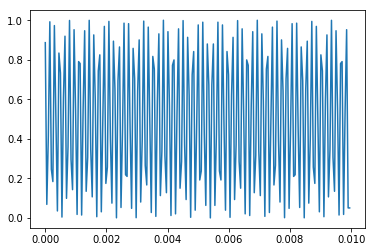

In [21]:
i = 0
selection = int(x_test.shape[1] * 0.2)
full = np.concatenate([x_test[i,-selection:,0],y_test[i,0]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

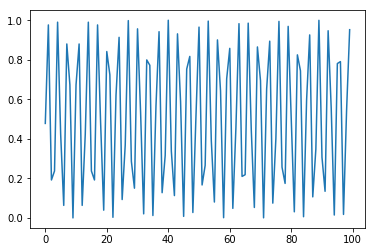

In [22]:
i = 0
# full = np.concatenate([x_test[i,-selection:],results[i]])
# n3 = full.shape[0]
plt.plot(x_test[0,-100:,0])